In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR, ExponentialSmoothing, SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [9]:
#


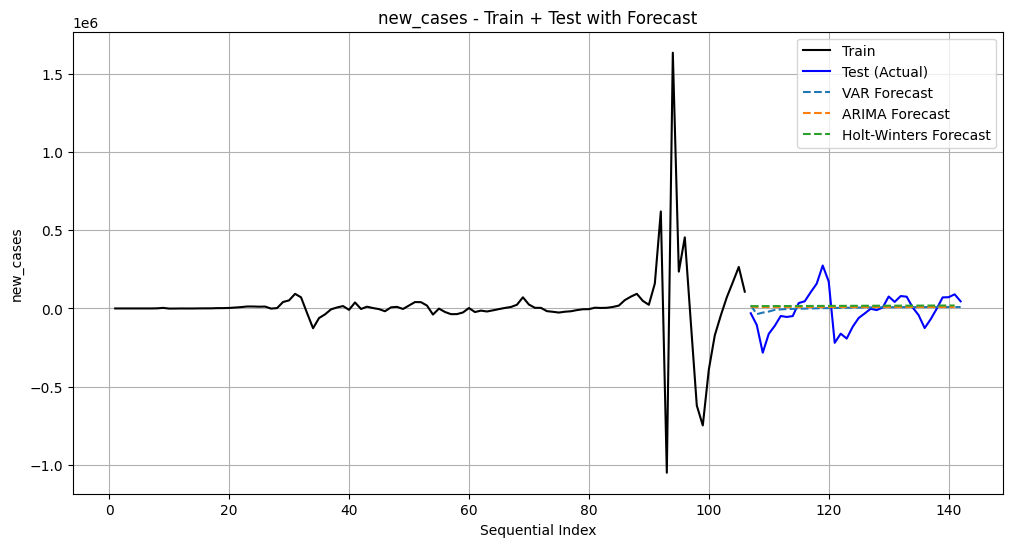

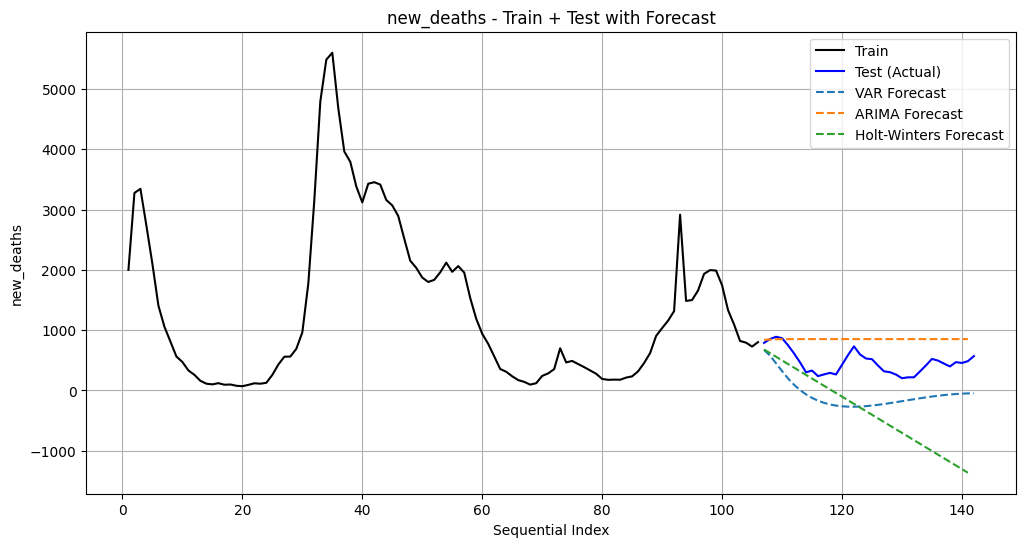

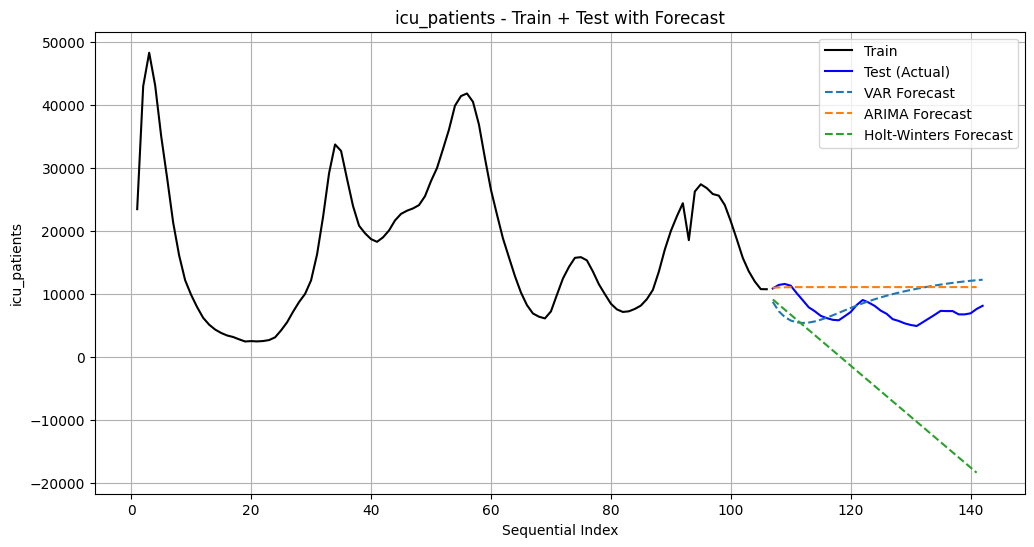

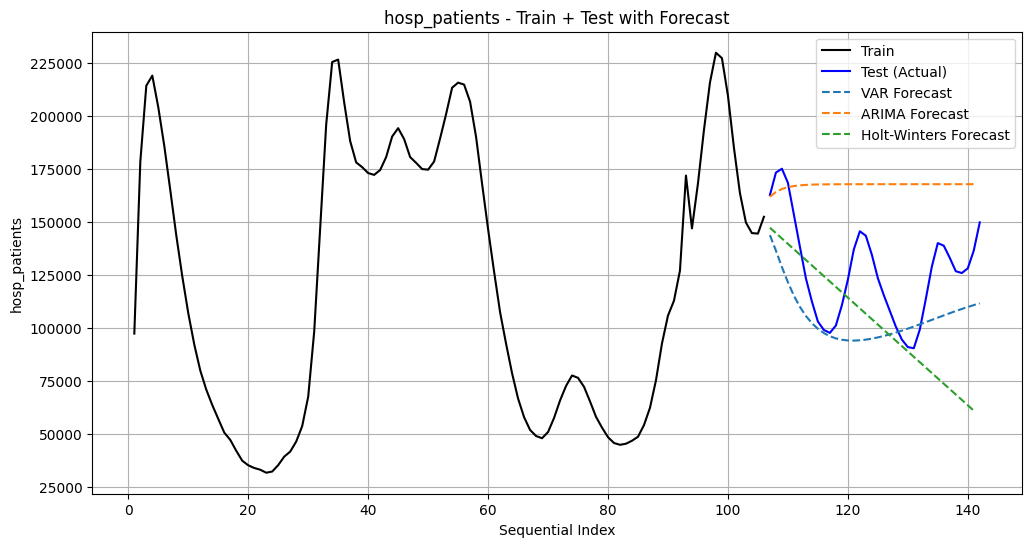

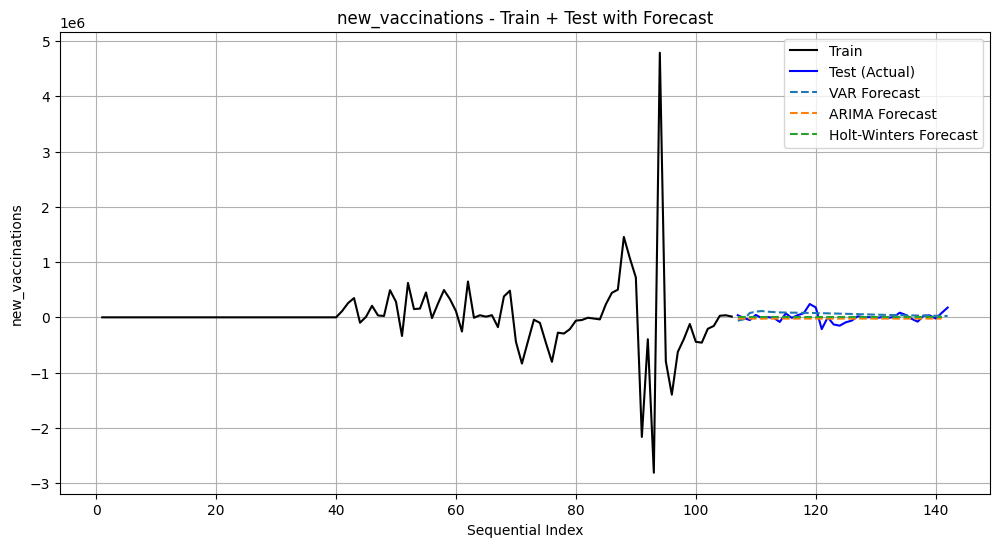

In [4]:
# ===========================
# Plotting Train + Test and Forecasts
# ===========================
forecast_methods = {
    "VAR": df_forecast_VAR,
    "ARIMA": df_forecast_ARIMA,

    "Holt-Winters": df_forecast_HW
}

for col in columns_to_plot:
    plt.figure(figsize=(12, 6))

    # Plot the full train + test data
    plt.plot(df_train.index, df_train[col], label='Train', color='black')
    plt.plot(df_test.index, df_test[col], label='Test (Actual)', color='blue')

    # Plot each forecast over the test period
    for method, forecast in forecast_methods.items():
        plt.plot(df_test.index, forecast[col], label=f'{method} Forecast', linestyle='--')

    plt.xlabel('Sequential Index')
    plt.ylabel(col)
    plt.title(f'{col} - Train + Test with Forecast')
    plt.legend()
    plt.grid(True)
    plt.show()


C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ACER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\l

RMSE Scores:

Method: VAR
new_cases: 111698.8247
new_deaths: 560.9436
icu_patients: 3797.2714
hosp_patients: 27187.2009
new_vaccinations: 108215.6867

Method: ARIMA
new_cases: 118163.8055
new_deaths: 433.9134
icu_patients: 4046.7979
hosp_patients: 48010.6162
new_vaccinations: 85798.6291

Method: Holt-Winters
new_cases: 119638.6063
new_deaths: 975.4248
icu_patients: 14064.9299
hosp_patients: 35337.8513
new_vaccinations: 82493.0188


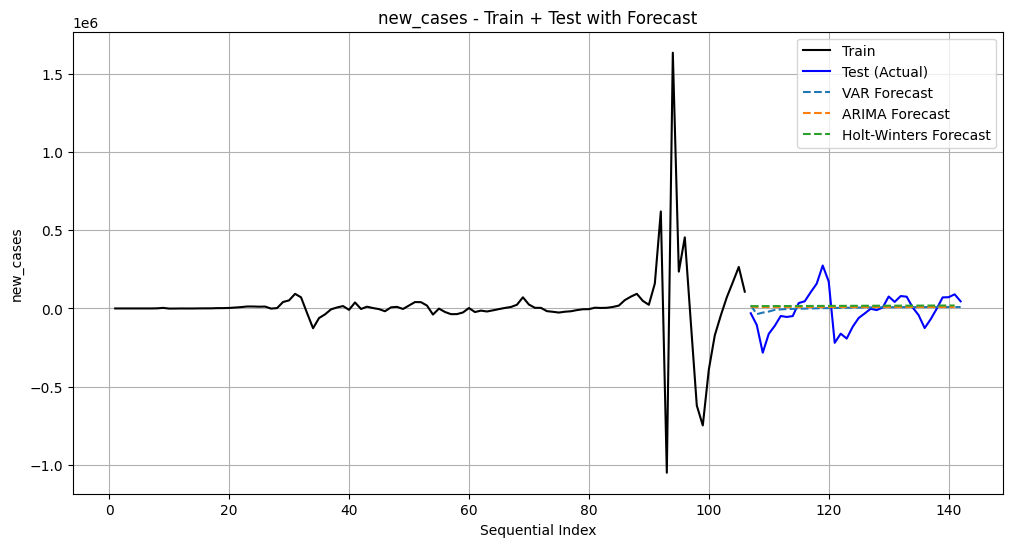

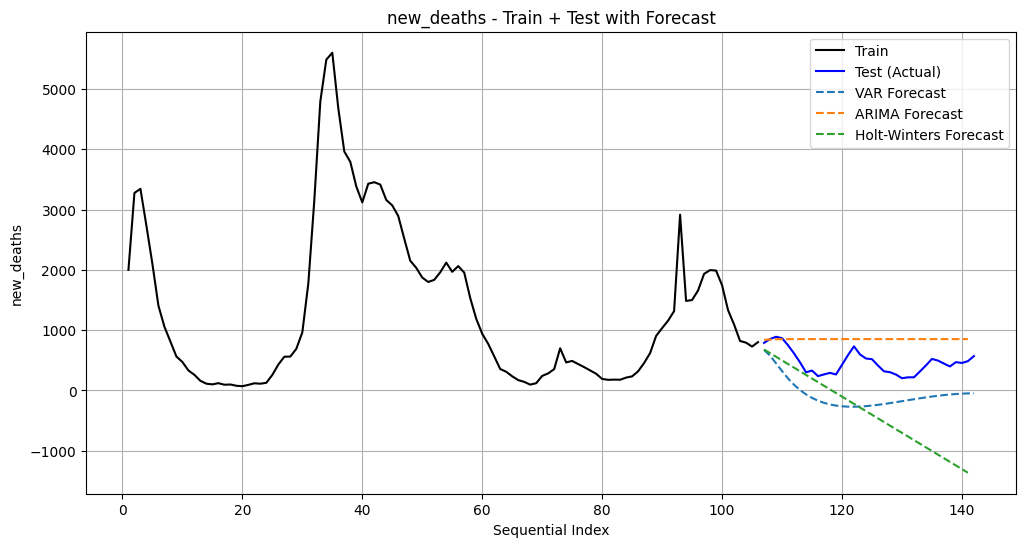

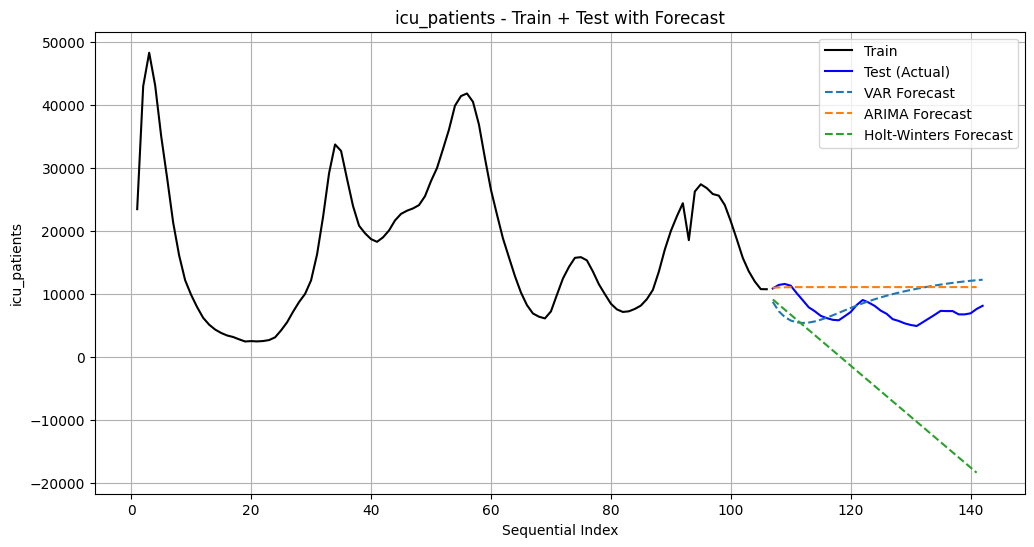

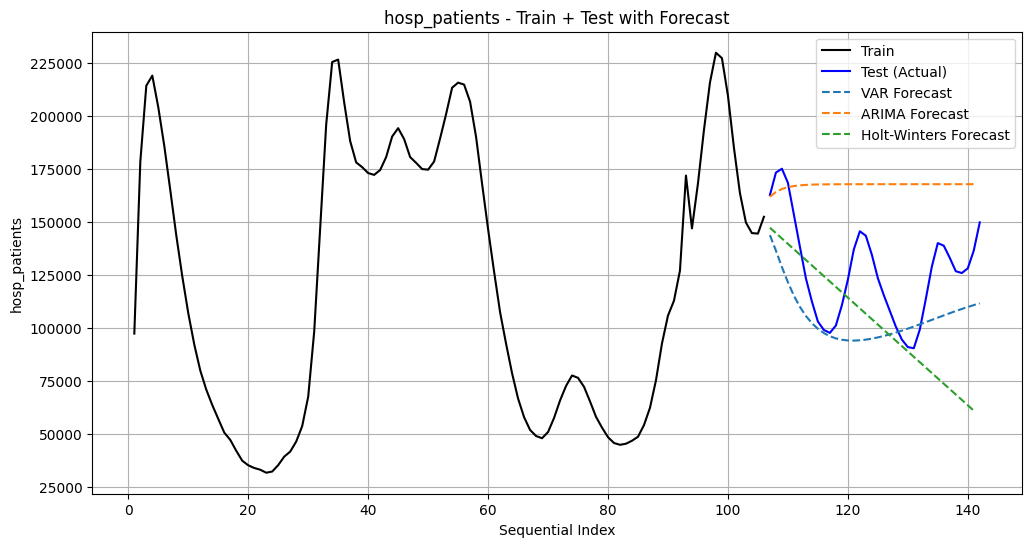

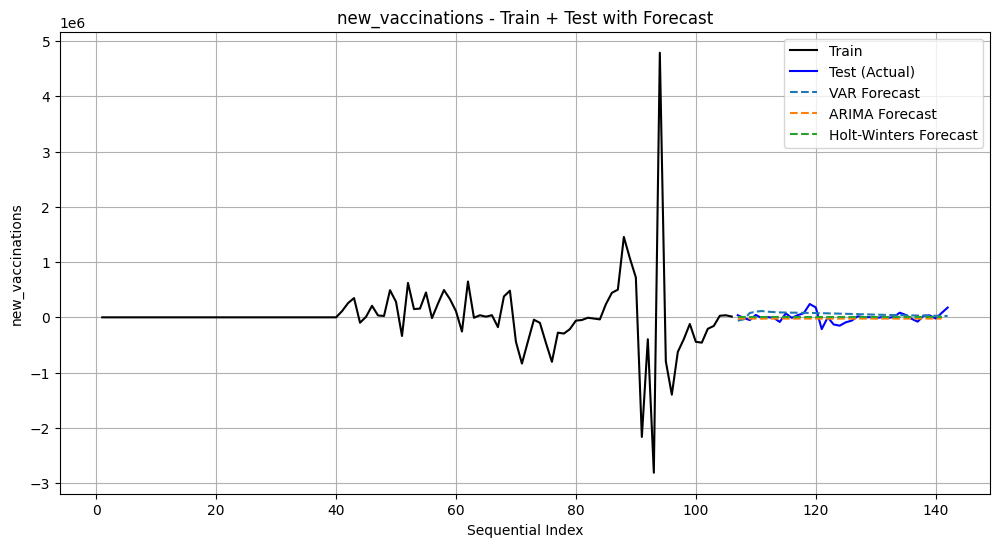

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR, SARIMAX, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

# Load and preprocess data
var_df = pd.read_csv("C:/Users/ACER/Downloads/covid TSAF/France_weekly_data_processed.csv")

# Sequential integer index (1, 2, 3, ...) and drop other index columns
var_df.reset_index(drop=True, inplace=True)
var_df.index = np.arange(1, len(var_df) + 1)

# Drop the last 15% of the data
drop_ratio = 0.1  # Adjust this to 0.10 or 0.20 as desired
cutoff = int(len(var_df) * (1 - drop_ratio))
var_df = var_df[:cutoff]

columns_to_plot = ['new_cases', 'new_deaths', 'icu_patients', 'hosp_patients', 'new_vaccinations']

# Function to check stationarity and apply differencing if needed
def adfuller_test(series, signif=0.05, name=''):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1] <= signif  # Stationary if p-value <= significance level

# Differencing to achieve stationarity
df_stationary = var_df.copy()
for column in columns_to_plot:
    stationary = adfuller_test(df_stationary[column], name=column)
    while not stationary:
        df_stationary[column] = df_stationary[column].diff().dropna()
        stationary = adfuller_test(df_stationary[column].dropna(), name=column)

df_stationary.dropna(inplace=True)
df_stationary.index = np.arange(1, len(df_stationary) + 1)

# Train-Test Split
test_frec = 0.25
n_test = round(len(df_stationary) * test_frec)
df_train, df_test = df_stationary[0:-n_test], df_stationary[-n_test:]

# Standardize data
scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), index=df_train.index, columns=df_train.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), index=df_test.index, columns=df_test.columns)

# ===========================
# VAR Model Forecasting
# ===========================
model = VAR(df_train_scaled)
model_fitted = model.fit()
forecast_steps = len(df_test_scaled)
forecast_scaled = model_fitted.forecast(df_train_scaled.values[-model_fitted.k_ar:], steps=forecast_steps)
df_forecast_VAR = pd.DataFrame(scaler.inverse_transform(forecast_scaled), index=df_test.index, columns=df_test.columns)

# ===========================
# ARIMA Model Forecasting
# ===========================
df_forecast_ARIMA = pd.DataFrame(index=df_test.index, columns=df_test.columns)
for col in columns_to_plot:
    model_arima = SARIMAX(df_train[col], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
    arima_fitted = model_arima.fit(disp=False)
    arima_forecast = arima_fitted.forecast(steps=forecast_steps)
    df_forecast_ARIMA[col] = arima_forecast

# ===========================
# Exponential Smoothing (ETS)
# ===========================
df_forecast_ETS = pd.DataFrame(index=df_test.index, columns=df_test.columns)
for col in columns_to_plot:
    model_ets = ExponentialSmoothing(df_train[col], trend='add', seasonal=None)
    ets_fitted = model_ets.fit()
    ets_forecast = ets_fitted.forecast(steps=forecast_steps)
    df_forecast_ETS[col] = ets_forecast

# ===========================
# Polynomial Regression (Degree 5)
# ===========================
df_forecast_poly = pd.DataFrame(index=df_test.index, columns=df_test.columns)
for col in columns_to_plot:
    # Prepare train data for polynomial regression
    X_train = np.arange(1, len(df_train) + 1).reshape(-1, 1)
    y_train = df_train[col].values
    # Fit polynomial regression (degree=5)
    poly_features = np.hstack([X_train**i for i in range(1, 6)])  # Degree 5 features
    poly_model = LinearRegression().fit(poly_features, y_train)
    # Prepare test data for forecasting
    X_test = np.arange(len(df_train) + 1, len(df_train) + 1 + forecast_steps).reshape(-1, 1)
    poly_features_test = np.hstack([X_test**i for i in range(1, 6)])
    poly_forecast = poly_model.predict(poly_features_test)
    df_forecast_poly[col] = poly_forecast

# ===========================
# Holt-Winters Model Forecasting
# ===========================
df_forecast_HW = pd.DataFrame(index=df_test.index, columns=df_test.columns)
for col in columns_to_plot:
    model_hw = ExponentialSmoothing(df_train[col], trend='add', seasonal=None)
    hw_fitted = model_hw.fit()
    hw_forecast = hw_fitted.forecast(steps=forecast_steps)
    df_forecast_HW[col] = hw_forecast

# ===========================
# Calculate and Print RMSE
# ===========================
forecast_methods = {
    "VAR": df_forecast_VAR,
    "ARIMA": df_forecast_ARIMA,
    
    
    "Holt-Winters": df_forecast_HW
}

rmse_scores = {}
for method, forecast in forecast_methods.items():
    method_rmse = {}
    for col in columns_to_plot:
        # Handle NaN values in RMSE calculations
        actual = df_test[col].dropna()
        pred = forecast[col].dropna()
        common_idx = actual.index.intersection(pred.index)
        rmse = np.sqrt(mean_squared_error(actual.loc[common_idx], pred.loc[common_idx]))
        method_rmse[col] = rmse
    rmse_scores[method] = method_rmse

# Print RMSE scores
print("RMSE Scores:")
for method, scores in rmse_scores.items():
    print(f"\nMethod: {method}")
    for col, score in scores.items():
        print(f"{col}: {score:.4f}")

# ===========================
# Plotting Train + Test and Forecasts
# ===========================
for col in columns_to_plot:
    plt.figure(figsize=(12, 6))
    # Plot the full train + test data
    plt.plot(df_train.index, df_train[col], label='Train', color='black')
    plt.plot(df_test.index, df_test[col], label='Test (Actual)', color='blue')
    # Plot each forecast over the test period
    for method, forecast in forecast_methods.items():
        plt.plot(df_test.index, forecast[col], label=f'{method} Forecast', linestyle='--')
    plt.xlabel('Sequential Index')
    plt.ylabel(col)
    plt.title(f'{col} - Train + Test with Forecast')
    plt.legend()
    plt.grid(True)
    plt.show()
